In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2, dt=0.001, Re=1.0)

simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['to'])

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

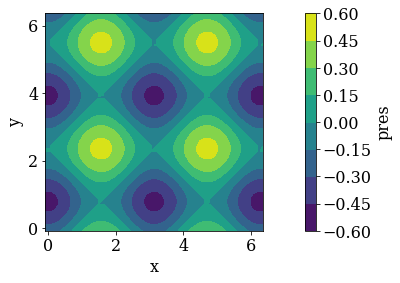

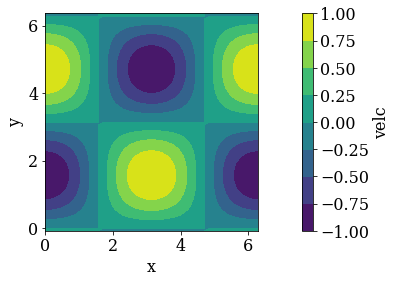

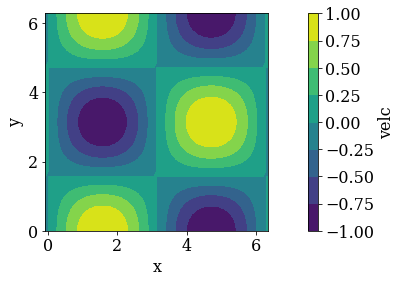

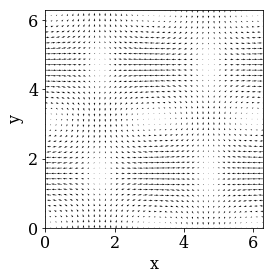

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])
    
    # Predictor Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')
    
    # Divergence Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                             poisson_options)
    # Corrector Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   
    
    scalars.advance()

------------ Time = 0.0 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.972981176514638e-13
Max, Min, U   : 0.9969173337331281, -0.996917333733128
Max, Min, V   : 0.996917333733128, -0.9969173337331281
Max, Min, P   : 1.8727542255516239, -1.0886441947452268
Max, Min, DIV : 7.216449660063518e-16, -7.771561172376096e-16


------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.4243646333993267e-13
Max, Min, U   : 0.9771770479217199, -0.9771770479217198
Max, Min, V   : 0.9771770479217198, -0.9771770479217199
Max, Min, P   : 0.689539469978557, -0.2572746681613052
Max, Min, DIV : 7.771561172376096e-16, -7.216449660063518e-16


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.092969951645601e-13
Max, Min, U   : 0.9578276459586815, -0.9578276459586814
Max, Min, V   : 0.9578276459586814, -0.9578276459586815
Max, Min, P   :

------------ Time = 0.2600000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.1295612940992688e-13
Max, Min, U   : 0.5926878395320042, -0.5926878395320042
Max, Min, V   : 0.5926878395320042, -0.5926878395320042
Max, Min, P   : -0.012380059582141415, -0.3608717697252324
Max, Min, DIV : 6.661338147750939e-16, -6.106226635438361e-16


------------ Time = 0.2700000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.3410765763597805e-13
Max, Min, U   : 0.5809518339943176, -0.5809518339943175
Max, Min, V   : 0.5809518339943175, -0.5809518339943176
Max, Min, P   : 0.2629703171949524, -0.07186133197291114
Max, Min, DIV : 6.661338147750939e-16, -6.661338147750939e-16


------------ Time = 0.2800000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0001195412454741e-12
Max, Min, U   : 0.5694482169363564, -0.5694482169363564
Max, Min, V   : 0.5694482169363564, -0.56944821693

------------ Time = 0.5100000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.4048697204362977e-13
Max, Min, U   : 0.3594833463150018, -0.35948334631500173
Max, Min, V   : 0.35948334631500173, -0.3594833463150018
Max, Min, P   : -0.17065660204967006, -0.298889262523025
Max, Min, DIV : 3.3306690738754696e-16, -3.3306690738754696e-16


------------ Time = 0.5200000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.7608599830321818e-13
Max, Min, U   : 0.3523650991338376, -0.35236509913383757
Max, Min, V   : 0.35236509913383757, -0.3523650991338376
Max, Min, P   : 0.22974087730429474, 0.10653543254161216
Max, Min, DIV : 3.608224830031759e-16, -3.469446951953614e-16


------------ Time = 0.5300000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.312639885604338e-13
Max, Min, U   : 0.34538780269059094, -0.3453878026905909
Max, Min, V   : 0.3453878026905909, -0.3453878

------------ Time = 0.7400000000000005 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.272514829192923e-13
Max, Min, U   : 0.226935957360763, -0.22693595736076297
Max, Min, V   : 0.22693595736076297, -0.226935957360763
Max, Min, P   : 0.145362221304671, 0.09425100635141405
Max, Min, DIV : 1.8041124150158794e-16, -2.220446049250313e-16


------------ Time = 0.7500000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.5355436642903123e-13
Max, Min, U   : 0.22244232433061828, -0.22244232433061825
Max, Min, V   : 0.22244232433061825, -0.22244232433061828
Max, Min, P   : -0.12431929115440393, -0.17342676350015362
Max, Min, DIV : 1.942890293094024e-16, -1.942890293094024e-16


------------ Time = 0.7600000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.6243722749548653e-13
Max, Min, U   : 0.21803767119614303, -0.218037671196143
Max, Min, V   : 0.218037671196143, -0.2180376711

------------ Time = 0.9700000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0595665566801393e-13
Max, Min, U   : 0.14326095845930673, -0.1432609584593067
Max, Min, V   : 0.1432609584593067, -0.14326095845930673
Max, Min, P   : -0.09434674393299518, -0.11472903926147447
Max, Min, DIV : 1.734723475976807e-16, -1.5265566588595902e-16


------------ Time = 0.9800000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.397909305836209e-13
Max, Min, U   : 0.14042420141846662, -0.14042420141846662
Max, Min, V   : 0.14042420141846662, -0.14042420141846662
Max, Min, P   : -0.12969855178363388, -0.1492826613373014
Max, Min, DIV : 1.6479873021779667e-16, -1.682681771697503e-16


------------ Time = 0.9900000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.3892116165841473e-14
Max, Min, U   : 0.13764361593054159, -0.13764361593054156
Max, Min, V   : 0.13764361593054156, -0.

------------ Time = 1.1999999999999786 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.9775099605498274e-14
Max, Min, U   : 0.09043830011501143, -0.09043830011501143
Max, Min, V   : 0.09043830011501143, -0.09043830011501143
Max, Min, P   : 0.05377078415608525, 0.04563659595851795
Max, Min, DIV : 9.020562075079397e-17, -9.71445146547012e-17


------------ Time = 1.2099999999999775 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.405341436692286e-14
Max, Min, U   : 0.08864750178885257, -0.08864750178885257
Max, Min, V   : 0.08864750178885257, -0.08864750178885257
Max, Min, P   : -0.00927556509464185, -0.017091375627351697
Max, Min, DIV : 8.326672684688674e-17, -7.979727989493313e-17


------------ Time = 1.2199999999999764 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.0831649162110374e-13
Max, Min, U   : 0.0868921636453917, -0.08689216364539169
Max, Min, V   : 0.08689216364539169, -0.08

------------ Time = 1.4399999999999522 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.6615431830375554e-15
Max, Min, U   : 0.05596637448826263, -0.05596637448826263
Max, Min, V   : 0.05596637448826263, -0.05596637448826263
Max, Min, P   : -0.005023281945613063, -0.00814426083731309
Max, Min, DIV : 4.85722573273506e-17, -4.85722573273506e-17


------------ Time = 1.449999999999951 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.150578493047365e-14
Max, Min, U   : 0.054858881219586514, -0.054858881219586514
Max, Min, V   : 0.05485888121958652, -0.054858881219586514
Max, Min, P   : -0.05927679830939378, -0.06227570946250361
Max, Min, DIV : 4.85722573273506e-17, -5.551115123125783e-17


------------ Time = 1.45999999999995 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.9363981447075625e-14
Max, Min, U   : 0.05377330789707364, -0.05377330789707364
Max, Min, V   : 0.05377330789707364, -0.0

------------ Time = 1.6799999999999258 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.2226308191701668e-14
Max, Min, U   : 0.03464271166695824, -0.03464271166695824
Max, Min, V   : 0.03464271166695824, -0.03464271166695824
Max, Min, P   : -0.021167498934259878, -0.02236596175551946
Max, Min, DIV : 4.119968255444917e-17, -3.9898639947466563e-17


------------ Time = 1.6899999999999247 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.209743009681702e-14
Max, Min, U   : 0.03395725444529169, -0.03395725444529169
Max, Min, V   : 0.03395725444529169, -0.03395725444529169
Max, Min, P   : -0.011574672439483824, -0.01272630599889448
Max, Min, DIV : 3.9898639947466563e-17, -3.642919299551295e-17


------------ Time = 1.6999999999999236 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.3693686364281256e-14
Max, Min, U   : 0.03328536325521856, -0.03328536325521855
Max, Min, V   : 0.03328536325521855

------------ Time = 1.9199999999998993 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.9995739812218e-15
Max, Min, U   : 0.0214447418985592, -0.0214447418985592
Max, Min, V   : 0.021444741898559203, -0.0214447418985592
Max, Min, P   : 0.00524407620632389, 0.004783388332285519
Max, Min, DIV : 2.0816681711721685e-17, -1.9949319973733282e-17


------------ Time = 1.9299999999998982 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.896046793077077e-14
Max, Min, U   : 0.021020479859133055, -0.021020479859133055
Max, Min, V   : 0.021020479859133055, -0.021020479859133055
Max, Min, P   : 0.037713364726576465, 0.03727065736420451
Max, Min, DIV : 2.2551405187698492e-17, -2.2551405187698492e-17


------------ Time = 1.9399999999998971 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.443267509084608e-14
Max, Min, U   : 0.02060461381695355, -0.02060461381695355
Max, Min, V   : 0.02060461381695355, -0

In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.variable['time'])

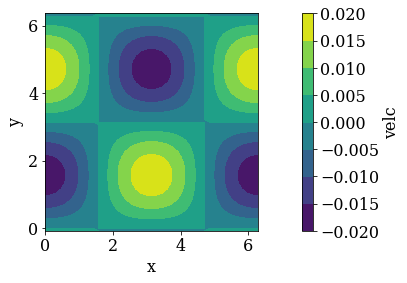

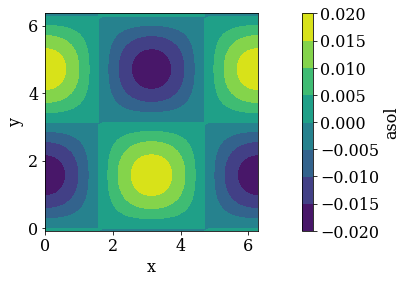

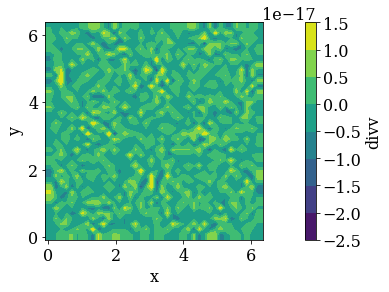

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divv')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

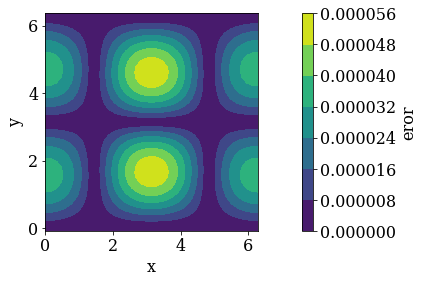

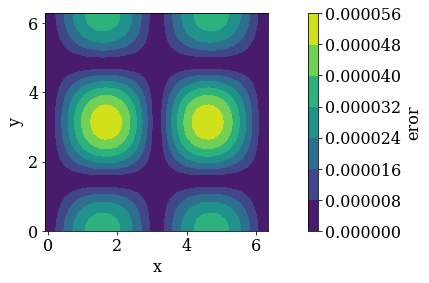

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')